In [ ]:
import sys
import os
import numpy as np
import time
from scipy.optimize import differential_evolution, minimize, dual_annealing
import matplotlib.pyplot as plt

import concurrent.futures
import threading
import multiprocessing
import pandas as pd

#sys.path.append("./../")
import minionpy as mpy

# Minimizing basic functions
-------------

In [2]:
def sphere(x) : 
    x =np.asarray(x)-1
    return 100+np.sum(x**2)

def rosenbrock(x):
    x = np.asarray(x)-1.0
    return 100+np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x):
    x = np.asarray(x)-1.0
    A = 10
    return 100+A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

#remember that in minion, objective function must be vectorized. Suppose you want to 
func = rosenbrock
def objective_function(X) : 
    """ 
    Here, X is a list of x, where x is an input vector. 
    """
    return [func(x) for x in X] 

#Now minimize the function using minion 
dimension = 2 #set dimension of the problem
maxevals = 10000 #number of function calls


min = mpy.Minimizer(func=objective_function, x0=None, bounds=[(-10, 10)]*dimension, algo="j2020", relTol=0.0, maxevals=10000, callback=None, seed=None, options={})
result = min.optimize()
print("The minimum of the function is ", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun)

The minimum of the function is  
	 x :  [2.000000071873379, 2.000000152840853] 
	 f(x) :  100.00000000000001


In [3]:
# You can also compare different algorithms 
dimension=10
maxevals = 10000
func = rosenbrock

algoList = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE"]
for algo in algoList : 
    result = mpy.Minimizer(func=objective_function, x0=None, bounds=[(-10, 10)]*dimension, algo=algo, relTol=0.0, 
                           maxevals=maxevals, callback=None, seed=None, options={"population_size":0}).optimize()
    print("Algorithm : ", algo, "\t f(x) : ", result.fun)

#compare to algorithms implemented in scipy 
res_DE = differential_evolution(func, bounds=[(-10, 10)]*dimension, strategy="best1bin", popsize=5*dimension, 
                                maxiter=int(maxevals/(5*dimension)-1), polish=False )
print("Algorithm : ", "Scipy DE", "\t f(x) : ", res_DE.fun)


res_minimize = minimize(func, x0 = [5.0 for _ in range(dimension)], method="Nelder-Mead", options={"maxfev": maxevals} )
print("Algorithm : ", "Scipy Nelder-Mead", "\t f(x) : ", res_minimize.fun)

res_dual = dual_annealing(func, bounds=[(-10, 10)]*dimension, maxfun=maxevals)
print("Algorithm : ", "Scipy Dual Annealing", "\t f(x) : ", res_dual.fun)

Algorithm :  DE 	 f(x) :  103.81893186521151
Algorithm :  LSHADE 	 f(x) :  102.84361712913218
Algorithm :  JADE 	 f(x) :  104.07876832291373
Algorithm :  jSO 	 f(x) :  102.74428171960075
Algorithm :  j2020 	 f(x) :  100.47444824706997
Algorithm :  LSRTDE 	 f(x) :  104.74083820762769
Algorithm :  NLSHADE_RSP 	 f(x) :  102.75771745578895
Algorithm :  ARRDE 	 f(x) :  102.09146691141873
Algorithm :  GWO_DE 	 f(x) :  107.55256004176681
Algorithm :  Scipy DE 	 f(x) :  101.51156700287441
Algorithm :  Scipy Nelder-Mead 	 f(x) :  103.9865791264969
Algorithm :  Scipy Dual Annealing 	 f(x) :  100.00000000133937


# Minimizing expensive function with multithreading/multiprocessing
--------



If the objective function is expensive to evaluate, then one can use multithreading to speeds up the calculation of the vectorized objective function. 
However, this requires that the objective function is thread-safe. If not, one can use multiprocessing. 

In [4]:
# Suppose the function to minimize is expensive to evaluate. In this case, multithreading helps. 
import time

def func(x) : 
    ret = rastrigin(x)
    time.sleep(0.01) #each evaluation will take 0.01s now. 
    return ret

#Batch calculation of the function above is calculated using threadpoolexecutor with the number of threads equal to Nthreads
Nthreads = 8
executor = concurrent.futures.ThreadPoolExecutor(max_workers=Nthreads) #executor for multithreading
#executor = concurrent.futures.ProcessPoolExecutor(max_workers=Nthreads) #executor for multiprocessing
def objective_function(X) : 
    ret = list(executor.map(func, X))
    return ret

#Now minimize the function using minion 
dimension = 5 #set dimension of the problem
maxevals = 1500 #number of function calls

now = time.time()
algo = "ARRDE"
min = mpy.Minimizer(func=objective_function, x0=None, bounds=[(-10, 10)]*dimension, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options={})
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")

#compared to scipy dual annealing that does not support multithreading natively
now = time.time()
res_dual = dual_annealing(func, bounds=[(-10, 10)]*dimension, maxfun=maxevals)
elapsed = time.time()-now
print("Algo : Scipy Dual Annealing ", "\n\t x : ", res_dual.x, "\n\t f(x) : ", res_dual.fun, "\n\t Elapsed: ", elapsed, " seconds")

#do not forget to shut down the executor
executor.shutdown()


Algo :  ARRDE 
	 x :  [1.9968465976067624, 0.9973853068241899, 1.995835230101065, 1.0016143763130512, 0.005077775008586325] 
	 f(x) :  102.98761003636226 
	 Elapsed:  2.7997095584869385  seconds

Algo : Scipy Dual Annealing  
	 x :  [1.         0.99999999 0.00504136 1.         0.99999999] 
	 f(x) :  100.99495905709331 
	 Elapsed:  15.699085712432861  seconds


# Algorithm comparisons using CEC benchmark problems
-------------


We can compare performance of different optimization algorithms by evaluating on congress on evolutionary computation (CEC) competition benchmark problems. Benchmark problems from the year 2011, 2014, 2017, 2019, 2020, 2022 are available in minion. 

CEC2014 and 2017 contains 30 problems which are implemented at dimension 10, 20, 30, 50, 100. 
CEC2019 contains 10 problems of varying dimensions. 
CEC2020 contains 10 problems of dimensions 5, 10, 15, 20 
CEC2022 contains 12 problems of dimensions 10, 20. 

These CEC problems typically contains some basic functions (such as Rosenbrock, Rastrigin, etc), hybrid functions (new function constructed from basic functions, where each component is evaluated from different basic functions), and composite functions (a linear combination of basic functions, whose coefficients are also functions of the input vector). These functions are also typicaly shifted and rotated. 

CEC2011 contains a set of real world problems, idealized and simplified to fit CEC. There are 22 problems of variying dimensions. Note that for cec2011, one need matlab installed in the system. n example on how to minimize cec2011 problems can be found in cec_11.py.  

In [5]:
#this cell will minimize CEC benchmark problems and repeated for Nruns times. 
# Global results variable
results = []
results_lock = threading.Lock()

def test_optimization(func, bounds, dimension, func_name, Nmaxeval, seed):
    global results
    result = {}
    result['Dimensions'] = dimension
    result['Function'] = func_name
    bounds_list = [bounds] * dimension
    x0 = [0.0 for _ in range(dimension)]

    for algo in algos :
        res = mpy.Minimizer (func, bounds_list, x0=None, relTol=0.0,  algo=algo, maxevals=Nmaxeval, 
                             callback=None, seed=seed, options={"population_size": 0}).optimize()
        result[algo] = res.fun

    def func_scipy (par) : 
        return func([par])[0]
    
    dual_ann = dual_annealing(func_scipy, bounds_list, maxfun=Nmaxeval)
    result["Scipy dual annealing"] = dual_ann.fun

    with results_lock:
        results.append(result)
    print(result)

def run_test_optimization(j, dim, year=2017, seed=None):
    if year== 2014 : cec_func = mpy.CEC2014Functions(function_number=j, dimension=dim)
    elif year== 2017 : cec_func = mpy.CEC2017Functions(function_number=j, dimension=dim)
    elif year== 2019 : cec_func = mpy.CEC2019Functions(function_number=j)
    elif year== 2020 : cec_func = mpy.CEC2020Functions(function_number=j, dimension=dim)
    elif year== 2022 : cec_func = mpy.CEC2022Functions(function_number=j, dimension=dim)
    else : raise Exception("Unknown CEC year.")
    test_optimization(cec_func, (-100, 100), dim, "func_" + str(j), Nmaxeval, seed)


#algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE"]
algos = ["LSRTDE", "ARRDE"]

Nmaxeval = 20000 #maximum number of function calls
dimension = 20
NRuns= 1 #number of repeats
year = 2022  #cec year

func_numbers_dict = {
    2022 :  [1,2,3,4,5,6,7, 8, 9,10, 11, 12] , 
    2020 : [1,2,3,4,5,6,7, 8, 9,10], 
    2019 : [1,2,3,4,5,6,7, 8, 9,10], 
    2017 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 
    2014 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
}
func_numbers= func_numbers_dict[year]


with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = []
    for k in range(NRuns):
        for j in func_numbers:
            futures.append(executor.submit(run_test_optimization, j, dimension, year, k))
    concurrent.futures.wait(futures)
    for f in futures: f.result()

#report best, average, and std of the optimization results. 
for num in func_numbers : 
    mydict= {}
    algoRes = {algo : [] for algo in algos}
    for res in list(results) : 
        for algo in algoRes.keys() : 
            if res['Function'] == "func_"+str(num) :
                algoRes[algo].append(res[algo])

    full_results= {}
    for key, val in algoRes.items() : 
        full_results[key] = (np.min(val), np.mean(val), np.std(val)) #best, average, std
    print("Full results for function "+str(num) +":\n\t", full_results)


{'Dimensions': 20, 'Function': 'func_1', 'LSRTDE': 301.07839856273637, 'ARRDE': 303.380053337027, 'Scipy dual annealing': 300.00007086027665}
{'Dimensions': 20, 'Function': 'func_2', 'LSRTDE': 449.09542291233424, 'ARRDE': 449.08523493462144, 'Scipy dual annealing': 400.00000067595016}
{'Dimensions': 20, 'Function': 'func_3', 'LSRTDE': 600.1046023675195, 'ARRDE': 600.08960562384, 'Scipy dual annealing': 606.5442156621559}
{'Dimensions': 20, 'Function': 'func_4', 'LSRTDE': 903.2747369388162, 'ARRDE': 819.8992365609473, 'Scipy dual annealing': 913.424505372674}
{'Dimensions': 20, 'Function': 'func_5', 'LSRTDE': 900.2104985070931, 'ARRDE': 900.0000319826036, 'Scipy dual annealing': 3559.240118485198}
{'Dimensions': 20, 'Function': 'func_6', 'LSRTDE': 1823.7118637458818, 'ARRDE': 1900.5811274759478, 'Scipy dual annealing': 1810.5720548716981}
{'Dimensions': 20, 'Function': 'func_7', 'LSRTDE': 2029.4489184576958, 'ARRDE': 2028.1659484277336, 'Scipy dual annealing': 2214.6648252099594}
{'Dime

# Example of using minion/py in curve fitting problems
--------------------
Here, an example of using minion to minimize an objective function related to a curve fitting problem is demonstrated. 
The idea is first to define the data generation model, generate the data, fit the model, and report the result. 

## Polynomial Fitting Problems

ARRDE  :  8.402411012551001e-05
LSHADE  :  0.010478868856562554
LSRTDE  :  0.0002594099083986417
Dual Annealing :  1.0215221609760433e-06


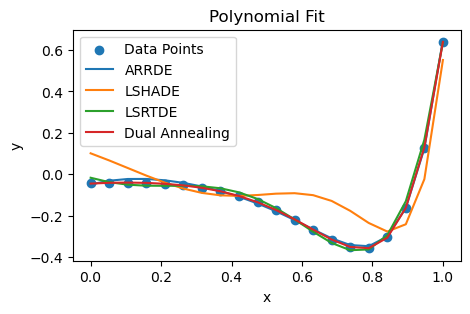

In [9]:
dimension=10 #the number of free parameters. The polynomial degree is just dimension-1
# Step 1: Generate data points from a polynomial 
np.random.seed(8)  # For reproducibility
# True coefficients of the polynomial (degree 10)
true_coefficients = [np.random.uniform(-1.0, 1.0)*1.0**i for i in range(dimension)]  # Random coefficients for the polynomial

# Generate dimension+10 data points
x_data = np.linspace(0.0, 1, dimension+10)
y_data = (np.polyval(true_coefficients, x_data))

# Step 2: Define the polynomial model
def polynomial_model(x, coefficients):
    """Given x and coefficients, return the polynomial value."""
    return (np.polyval(coefficients, x))

# Step 3: Define the objective function to minimize
def objective_function(coefficients):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = polynomial_model(x_data, coefficients)
    return np.mean((y_data - y_pred)**2)

def objective_function_vect(X) : 
    return [objective_function(x) for x in X ]


bounds= [(-10, 10)]*dimension
Nmaxeval= 2000
algos = ["ARRDE", "LSHADE", "LSRTDE" ]

# Step 4: Minimize the obj function and plot the results
plt.figure(figsize=(5,3))
plt.scatter(x_data, y_data, label='Data Points')

for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=None, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, polynomial_model(x_data, res.x ), label=algo)

dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval)
print("Dual Annealing : ", dual_ann.fun)
plt.plot(x_data, polynomial_model(x_data, dual_ann.x ), label="Dual Annealing")
plt.legend()
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Gaussian Mixture Model Fitting Problems

LSRTDE  :  0.005511431222873861
ARRDE  :  5.2878362374846714e-05
Dual Annealing :  0.0033093180180329917


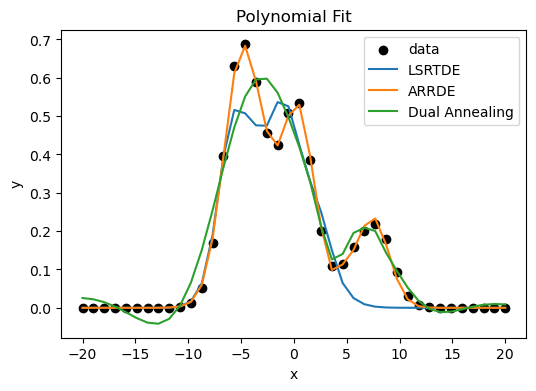

In [11]:
np.random.seed(5)  # For reproducibility

num_rbf = 10
true_centers = 10*(-1+2*np.random.random(num_rbf))
true_widths = np.random.rand(num_rbf) + 1.0  # Widths (variances)
true_coeffs = 2.0*np.random.rand(num_rbf)
dimension= num_rbf*3

# Define a Gaussian function
def gauss(x, center, width):
    """Compute a Gaussian RBF value given x, center, and width."""
    return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Define the function as a weighted sum of gaussians
def gmm(x, centers, widths, coeffs):
    result = np.zeros_like(x)
    coeffs= np.array(coeffs)
    norm_coeff = coeffs/np.sum(coeffs)
    for i in range(len(centers)):
        result += norm_coeff[i] * gauss(x, centers[i], widths[i])
    return result


# Generate dimension+10 data points
x_data = np.linspace(-20, 20,dimension+10)
y_data = gmm(x_data, true_centers, true_widths, true_coeffs)

# Step 2: Define the model for fitting
def gmm_model(x, params):
    """ model with combined parameters (centers, widths, and coefficients)."""
    num_rbf = len(params) // 3
    centers = params[:num_rbf]
    widths = params[num_rbf:2*num_rbf]
    coeffs = params[2*num_rbf:]
    return gmm(x, centers, widths, coeffs)

# Step 3: Define the objective function to minimize
def objective_function(params):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = gmm_model(x_data, params)
    return np.mean((y_data - y_pred) ** 2)


executor = concurrent.futures.ThreadPoolExecutor(max_workers=4)
def objective_function_vect(params) : 
    ret = list(executor.map(objective_function, params))
    return ret


bounds= [(-10, 10)]*dimension
Nmaxeval=10000
algos = ["LSRTDE", "ARRDE"]

plt.figure(figsize=(6,4))
plt.scatter(x_data, y_data, label="data", color="black")
for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=None, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=None, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, gmm_model(x_data, res.x ), label=algo)

dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval)
print("Dual Annealing : ", dual_ann.fun)
plt.plot(x_data, gmm_model(x_data, dual_ann.x ), label="Dual Annealing")
plt.legend()
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

executor.shutdown()
